# Standard scanpy workflow version 2.8 #


Data loaded here is the concatenation of the human samples of islet cells load from GSE84133.

Inital processing step was by reading all individual samples and using concatenate from scanpy.


Here, no filtering will be performed initially but 

### Import section ###

In [43]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
sc.logging.print_versions()

import logging
import seaborn as sns

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0


## Setup Standard Wokflow

### Parameters to be set - on the command line or here ###

In [44]:
# decisions to be made
species = 'human'
batch_to_correct = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
analysis_name =  'standard_workflow_besca2.0'
split_condition = 'Individual' #'experiment' is generally a good default
dynrange=['B2m','Actb','Pgk1','Ctcf'] #genes for which to plot dynamic range
if species=='human': dynrange=[x.upper() for x in dynrange]

#additional labeling
labeling_to_use = 'assigned_cluster'# must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
labeling_name = 'assigned_cluster' # define name under which the labeling should be exported
labeling_description = 'celltype annotation from the paper' #define description which should be saved to labeling_info file
labeling_author = 'Baron' #define author which shoudl be saved to labeling info file

### Define Input ###

In [45]:
# define filepath (this is the folder that contains "raw" and "analyzed")
root_path = os.getcwd()

### Standard parameters - these should be kept as stable as possible ###

In [46]:
# the standard parameter section
standard_min_genes = 500
standard_min_cells = 30
standard_min_counts = 1000
standard_n_genes = 5000 # this is the most tricky one to set
standard_percent_mito = 0.1
standard_max_counts = 140000 #might be redundant with n_genes

## Standard Pipeline
(note nothing below this point should be modified!!)

In [47]:
#define standardized filepaths based on above input
results_folder = os.path.join(root_path, 'analyzed', analysis_name)
results_file = os.path.join(results_folder, analysis_name + '.h5ad') # specify a .h5ad file for storing the results
log_file = os.path.join(results_folder, analysis_name + '.standard.log') # specify a log file for keeping a short summary and overview
sc.settings.figdir = os.path.join(results_folder, 'figures')

#setup standard workflow (generates output directories and setsup logging file)
bc.st.setup(results_folder, 
          analysis_name, 
          labeling_name, 
          labeling_to_use, 
          log_file, 
          version,
          root_path, 
          species, 
          batch_to_correct, 
          standard_min_genes,
          standard_min_cells,
          standard_min_counts,
          standard_n_genes,
          standard_percent_mito,
          standard_max_counts)

#read input data

adata = sc.read_h5ad('raw/all_samples.h5ad')#bc.st.read_matrix(root_path)

LOG MESSAGE: Standard Pipeline Version 2.8 used
LOG MESSAGE: Standard Pipeline Version 2.8 used
LOG MESSAGE: 2020-05-15
LOG MESSAGE: 2020-05-15
LOG MESSAGE: Analysis 'standard_workflow_besca2.0' on data located in'./'
LOG MESSAGE: Analysis 'standard_workflow_besca2.0' on data located in'./'
LOG MESSAGE: species: human
LOG MESSAGE: species: human
LOG MESSAGE: Batch effect to correct: None
LOG MESSAGE: Batch effect to correct: None
LOG MESSAGE: Parameters:
LOG MESSAGE: Parameters:
LOG MESSAGE: 	standard_min_genes = 500
LOG MESSAGE: 	standard_min_genes = 500
LOG MESSAGE: 	standard_min_cells = 30
LOG MESSAGE: 	standard_min_cells = 30
LOG MESSAGE: 	standard_min_counts = 1000
LOG MESSAGE: 	standard_min_counts = 1000
LOG MESSAGE: 	standard_n_genes = 5000
LOG MESSAGE: 	standard_n_genes = 5000
LOG MESSAGE: 	standard_max_counts = 140000
LOG MESSAGE: 	standard_max_counts = 140000
LOG MESSAGE: 	standard_percent_mito = 0.1
LOG MESSAGE: 	standard_percent_mito = 0.1
LOG MESSAGE: 	Time for creating al

all output directories created successfully


# Dataset specific adaptation

We use an ad-hoc script to find ensembl id for the genes symbol and input this into our anndata object.
Additional, X is transformed into a sparse matrix.

In [48]:
import numpy as np
from scipy import sparse
adata.X = sparse.csr_matrix(adata.X)


In [49]:
ggnees = pd.read_csv('raw/genes_Symbol.csv.GOOD', skiprows= 1, sep = '\t', header = None)
ggnees.columns = ['ENSEMBL', 'SYMBOL', 'ORIG']
ggnees.replace("<class 'str'>", 'NotFOUND', inplace = True)


In [50]:
#tmp_var = adata.var
tmp_var = pd.merge(adata.var, ggnees, left_index=True, right_on='ORIG')
print(tmp_var.head(10))
tmp_var= tmp_var.set_index('SYMBOL')
tmp_var['SYMBOL'] = tmp_var.index.values
adata.var  = tmp_var[['ENSEMBL', 'SYMBOL']]


           ENSEMBL    SYMBOL    ORIG
0  ENSG00000121410      A1BG    A1BG
1  ENSG00000148584      A1CF    A1CF
2  ENSG00000175899       A2M     A2M
3  ENSG00000166535     A2ML1   A2ML1
4  ENSG00000128274    A4GALT  A4GALT
5  ENSG00000118017     A4GNT   A4GNT
6  ENSG00000265544  NotFOUND    AA06
7  ENSG00000094914      AAAS    AAAS
8  ENSG00000081760      AACS    AACS
9  ENSG00000250420    AACSP1  AACSP1


In [51]:
adata.var.head()

,ENSEMBL,SYMBOL
SYMBOL,,
A1BG,ENSG00000121410,A1BG
A1CF,ENSG00000148584,A1CF
A2M,ENSG00000175899,A2M
A2ML1,ENSG00000166535,A2ML1
A4GALT,ENSG00000128274,A4GALT


In [52]:
adata.obs.head()

,Individual,assigned_cluster,barcode
human1_lib1.final_cell_0001-GSM2230757_human1_umifm_counts,GSM2230757_human1_umifm_counts,acinar,GATGACGGAC-GGTGGGAT
human1_lib1.final_cell_0002-GSM2230757_human1_umifm_counts,GSM2230757_human1_umifm_counts,acinar,GAGCGTTGCT-ACCTTCTT
human1_lib1.final_cell_0003-GSM2230757_human1_umifm_counts,GSM2230757_human1_umifm_counts,acinar,CTTACGGG-CCATTACT
human1_lib1.final_cell_0004-GSM2230757_human1_umifm_counts,GSM2230757_human1_umifm_counts,acinar,GATGTACACG-TTAAACTG
human1_lib1.final_cell_0005-GSM2230757_human1_umifm_counts,GSM2230757_human1_umifm_counts,acinar,GAGATTGCGA-GTCGTCGT


In [53]:
adata.var_names_make_unique()

# Continuing standard_workflow

In [54]:
#calculate mitochondrial gene content
bc.pp.fraction_counts(adata=adata, species='human', use_genes= 'ENSEMBL')

None of the genes from input list found in data set.                Please ensure you have correctly specified use_genes to match                the type of genes saved in adata.var_names.


### Visualization of quality control plots and selected filtering parameters

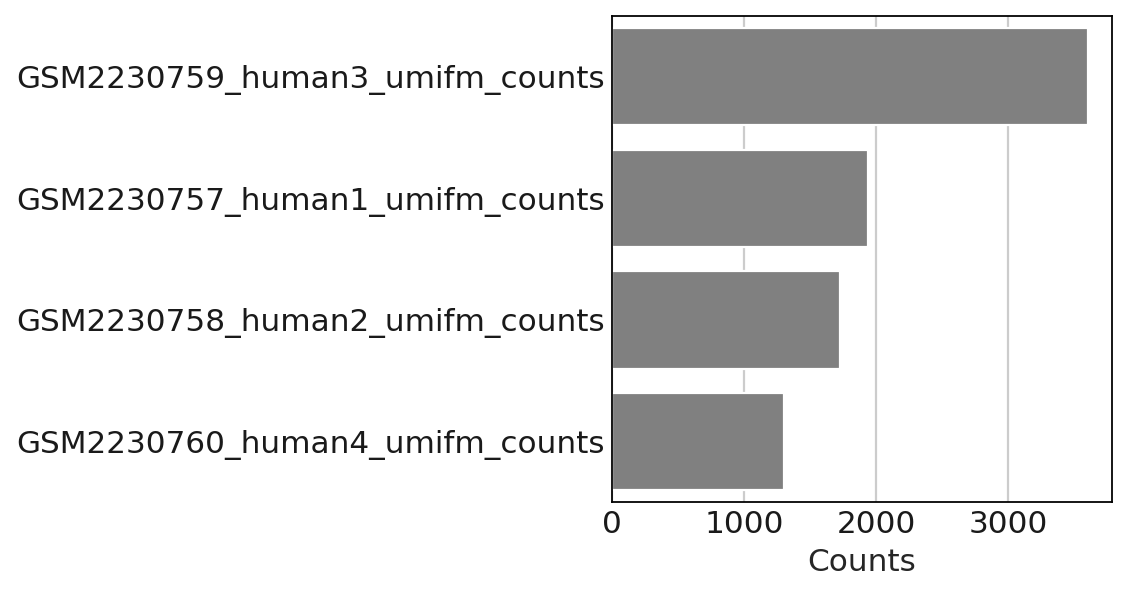

In [55]:
### have a look at cell nrs per sample ### 
temp=bc.tl.count_occurance(adata,split_condition)
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

# Additional visualization using metadata from publication



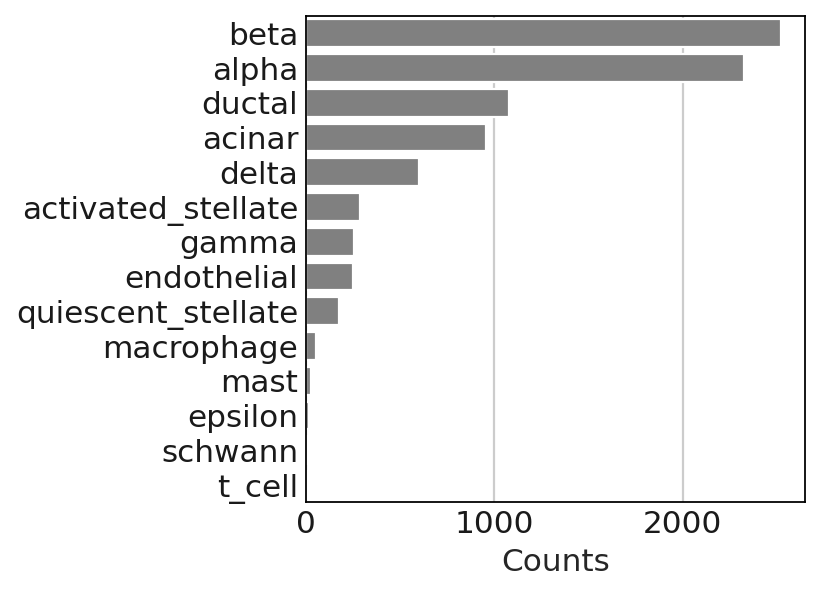

In [56]:
temp=bc.tl.count_occurance(adata,'assigned_cluster')
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

##### Transcript Capture Efficiency
This plot gives you an idea about the sequencing depth and if the sequencing has reached saturation or not.

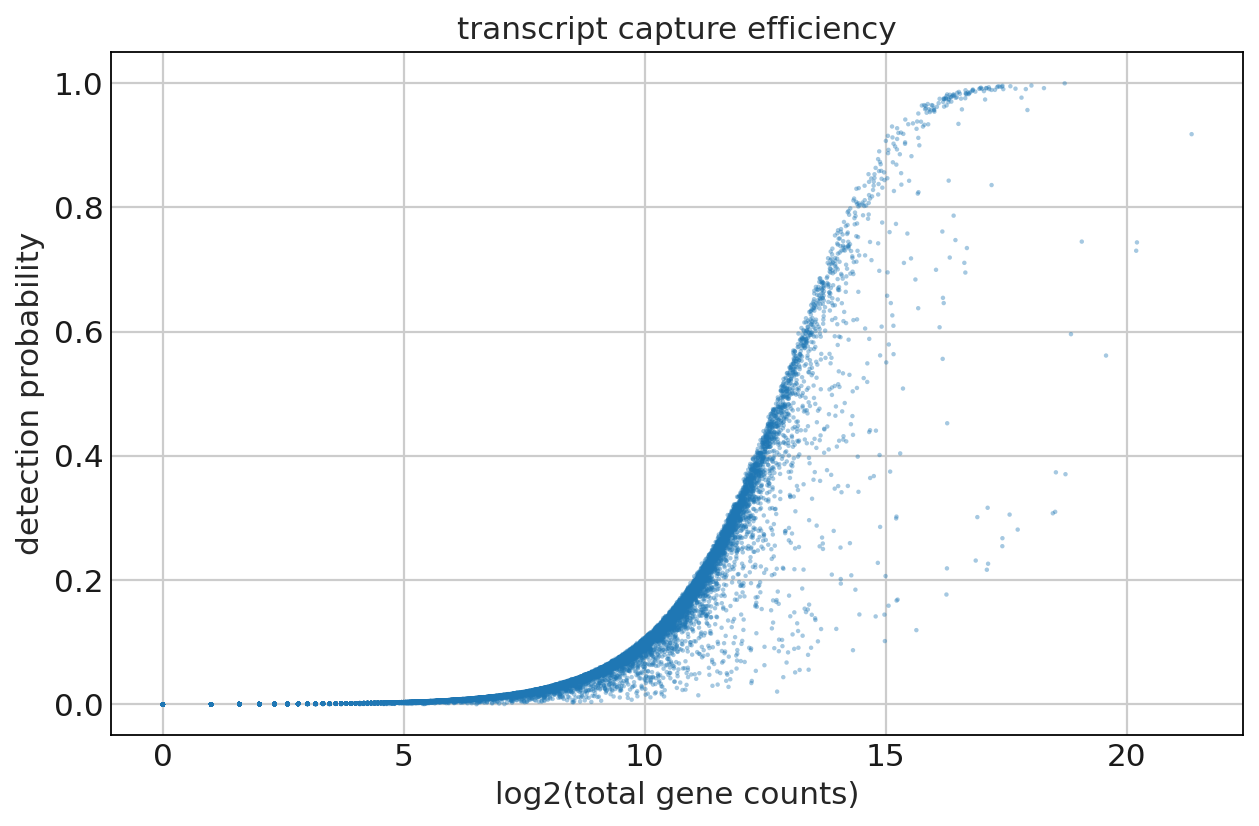

In [57]:
fig, ax = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(5)
fig.tight_layout()

bc.pl.transcript_capture_efficiency(adata,ax=ax)
fig.savefig(os.path.join(results_folder, 'figures/transcriptcaptureefficiency.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

##### Library Size distribution
This plot gives you an idea about the library size distribution in your dataset before processing.

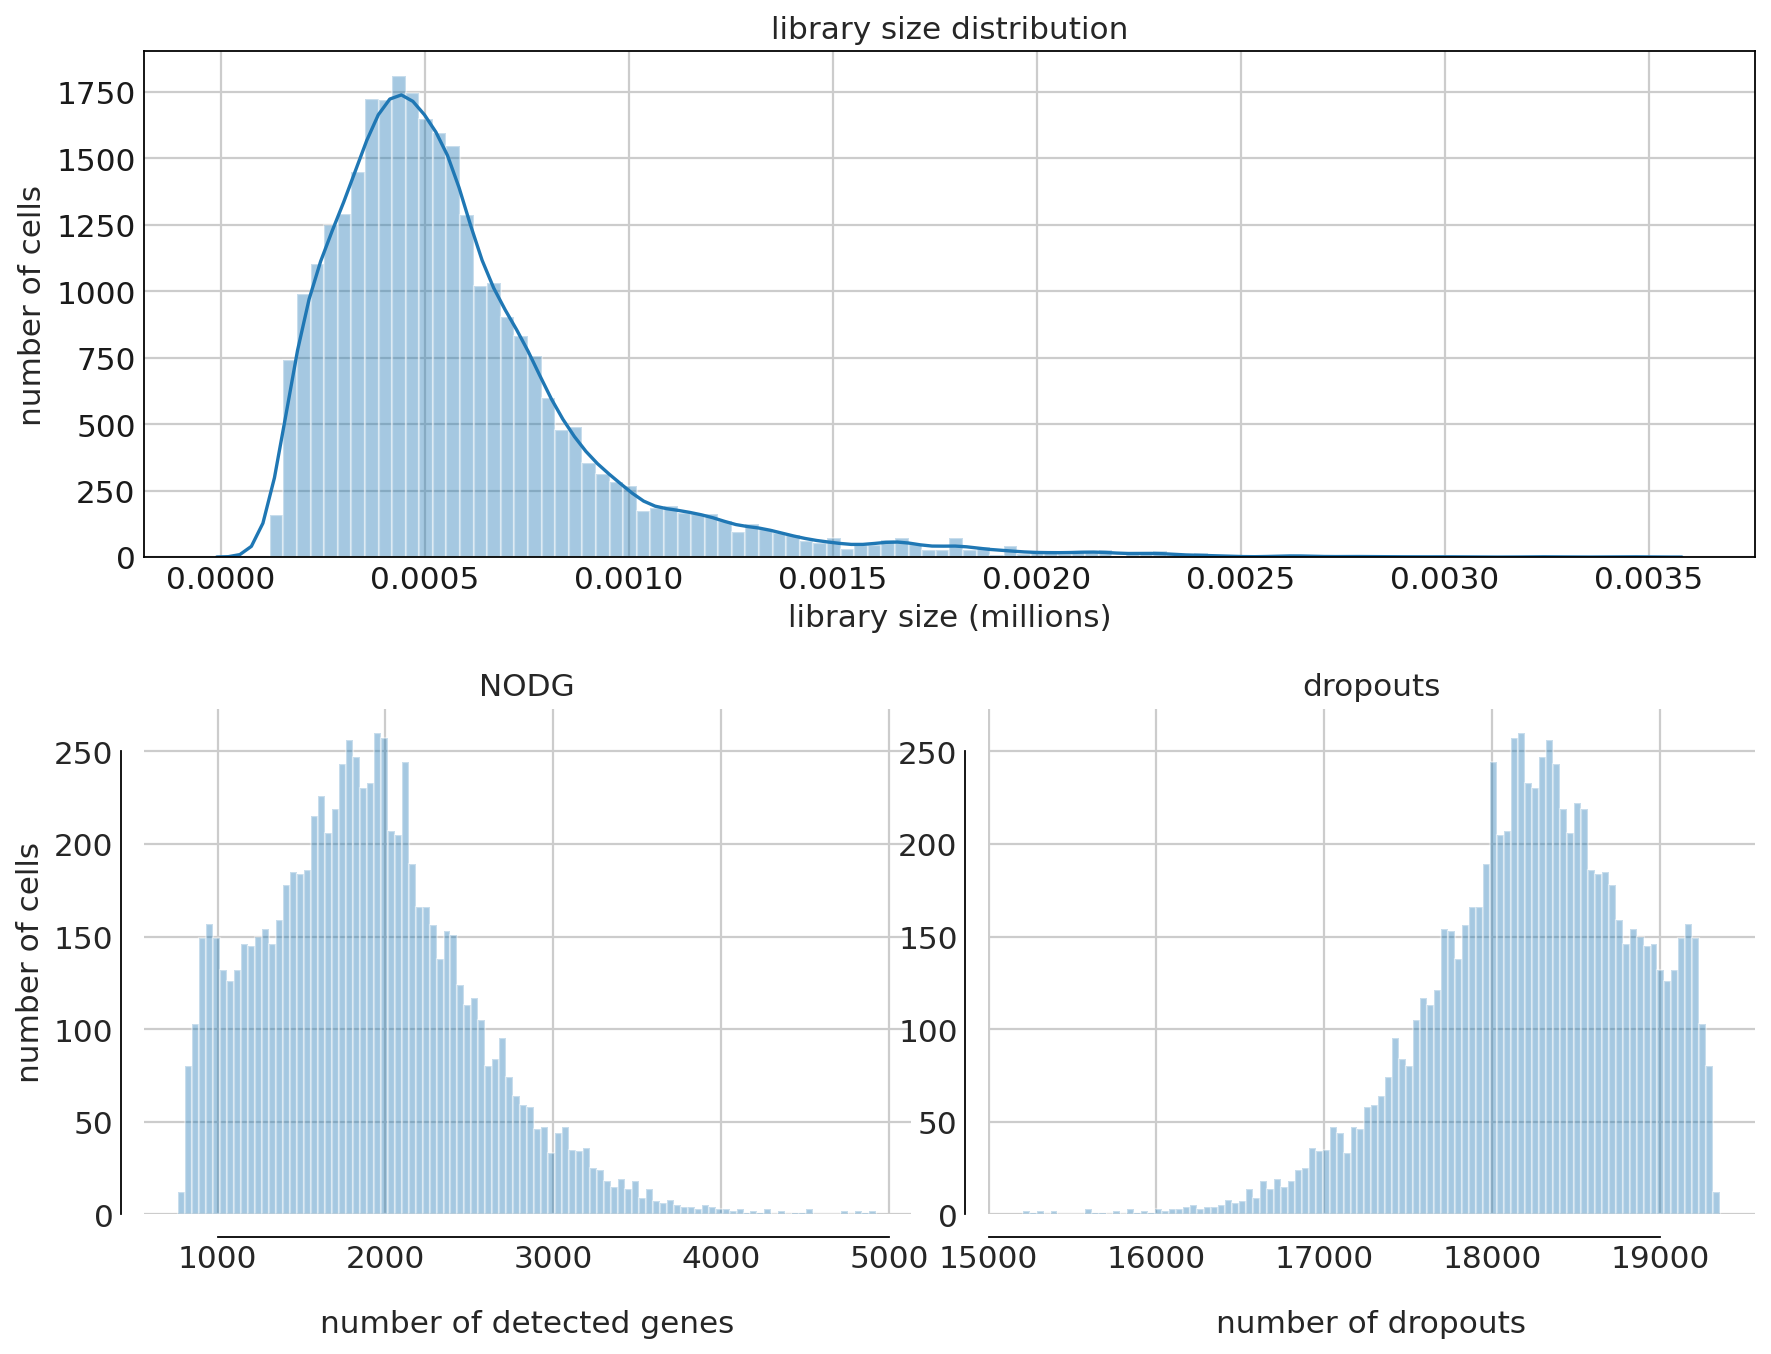

In [58]:
fig = bc.pl.librarysize_overview(adata, bins=100)
fig.savefig(os.path.join(results_folder, 'figures/librarysize.png'), format='png',bbbox_inches = 'tight') #save figure for QC report

In [59]:
adata_unfiltered = adata.copy()


##### Selected Filtering Parameters

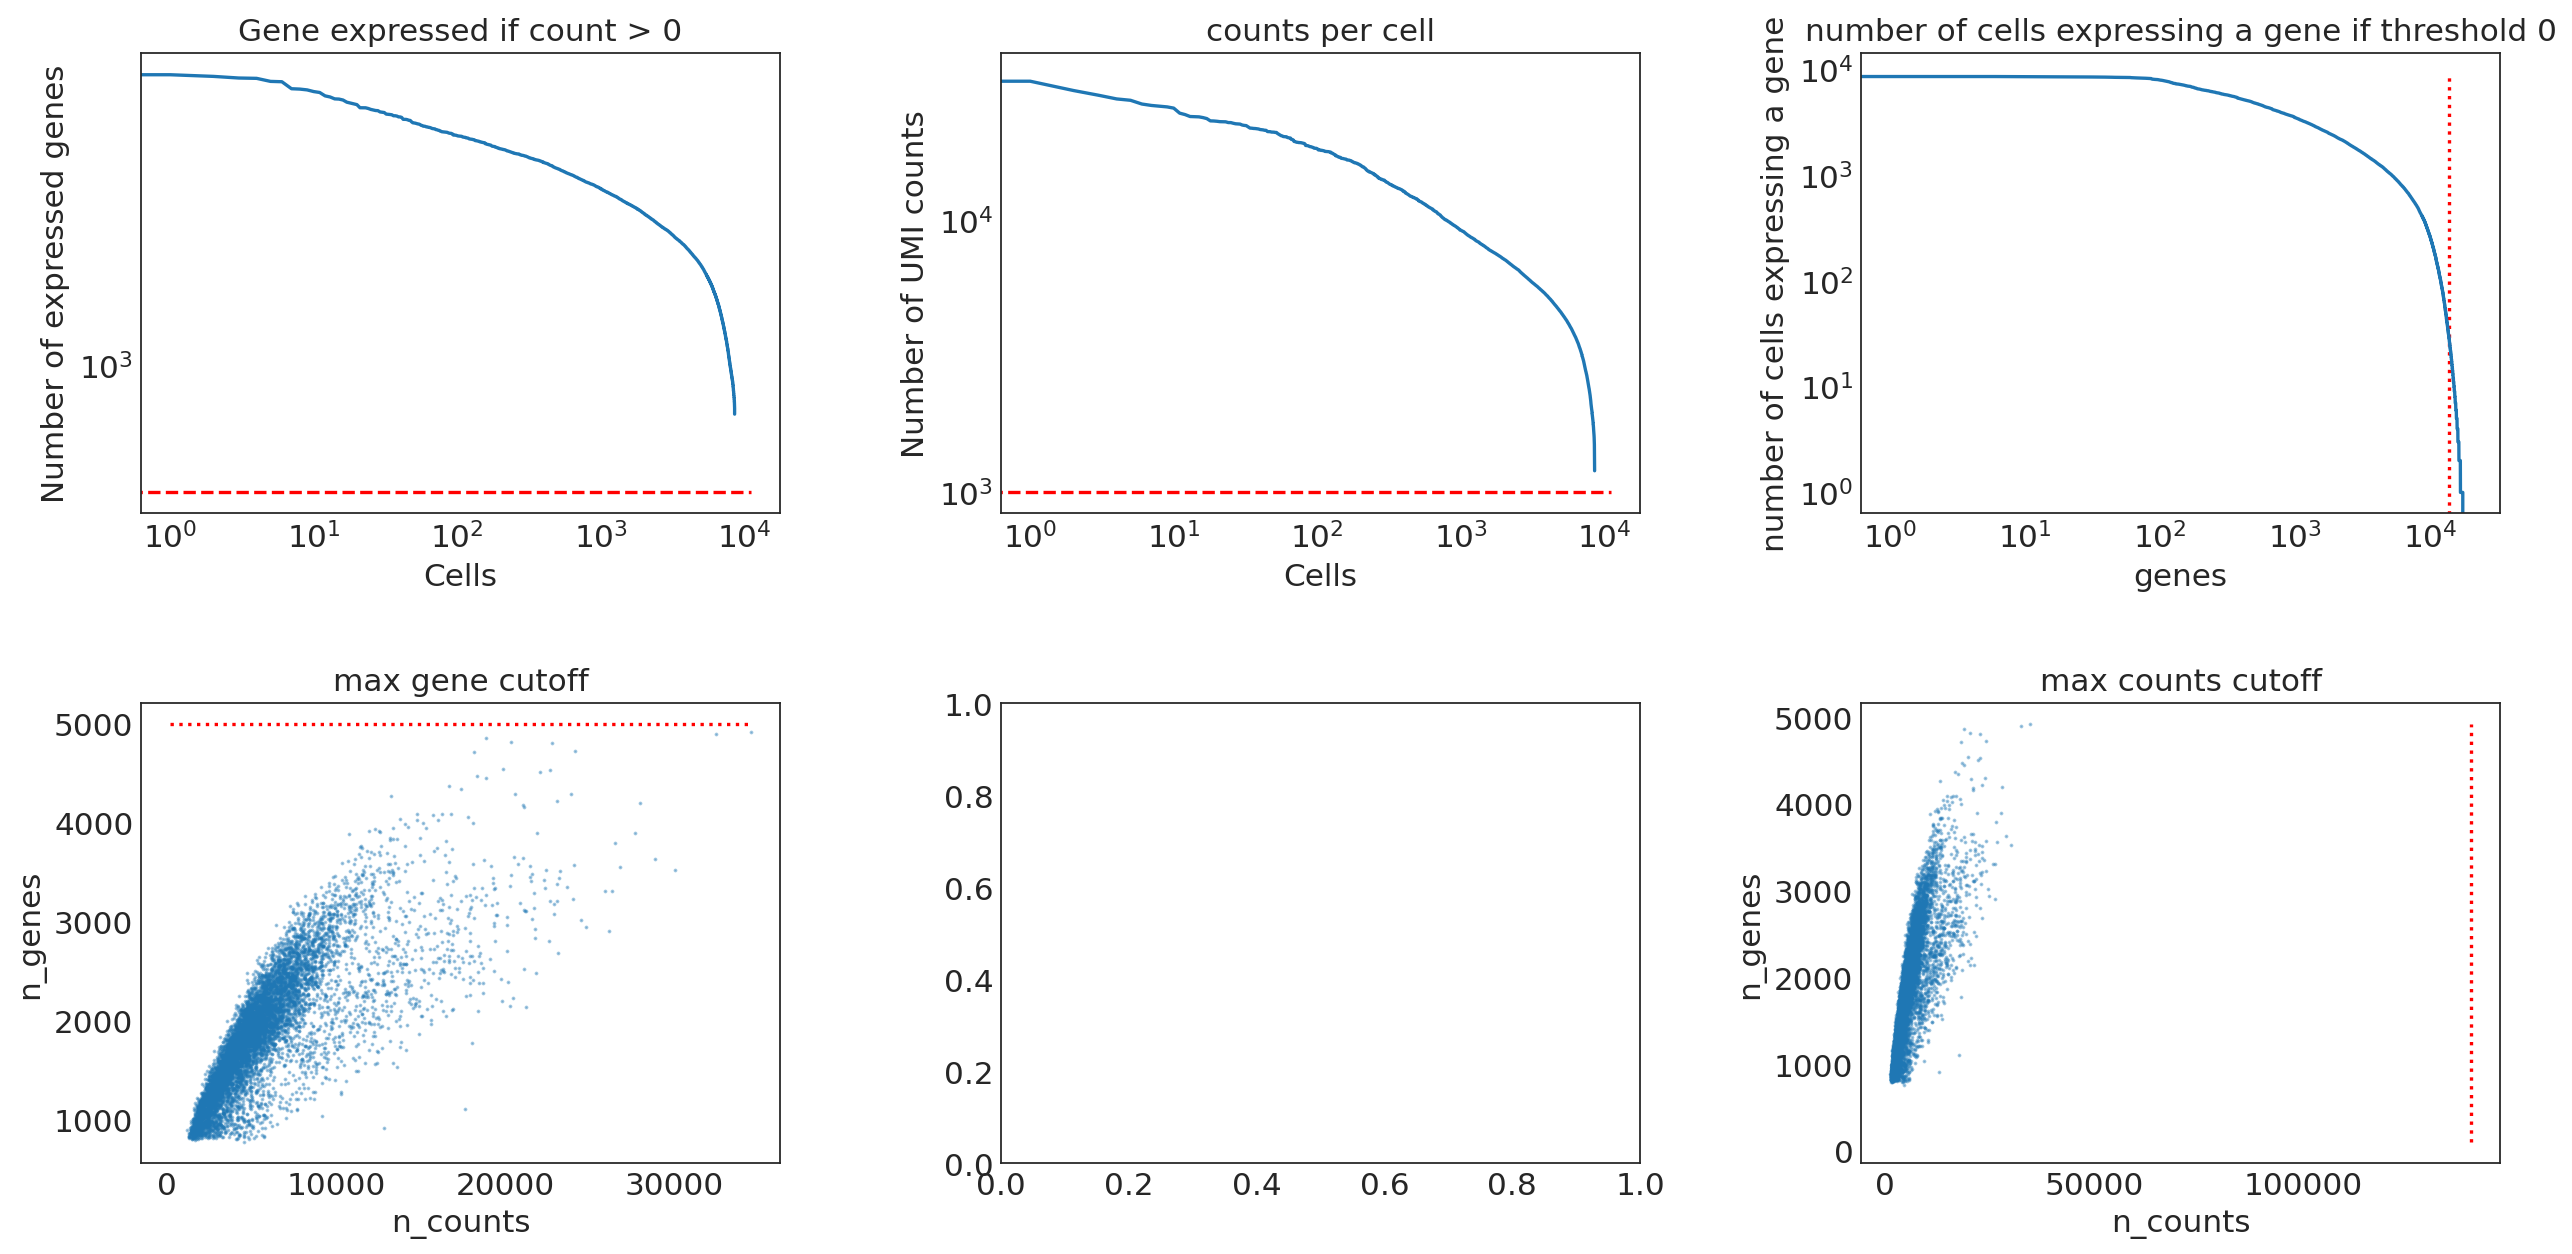

In [60]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(17)
fig.set_figheight(9)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=standard_min_genes, ax = ax1)
bc.pl.kp_counts(adata, min_counts=standard_min_counts, ax = ax2)
bc.pl.kp_cells(adata, min_cells=standard_min_cells, ax = ax3)
bc.pl.max_genes(adata, max_genes=standard_n_genes, ax = ax4)
#bc.pl.max_mito(adata, max_mito=standard_percent_mito, annotation_type='SYMBOL', species=species, ax = ax5)
bc.pl.max_counts(adata, max_counts=standard_max_counts, ax=ax6)
fig.savefig(os.path.join(results_folder, 'figures/filtering_thresholds.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

./.conda/envs/Besca_DEV/lib/python3.8/site-packages/anndata/_core/anndata.py:1176: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

... storing 'ENSEMBL' as categorical
... storing 'SYMBOL' as categorical


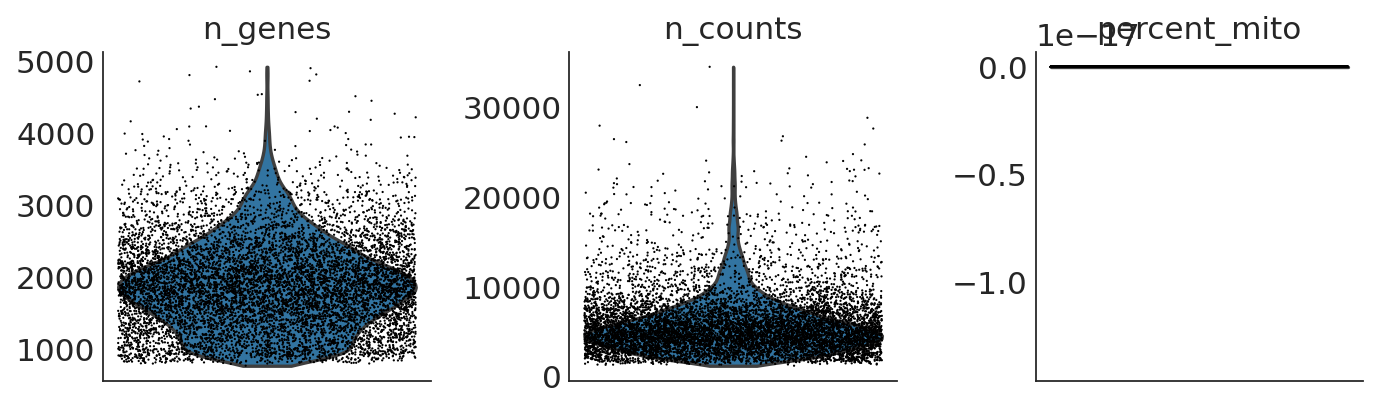

In [61]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.before_filtering.png')

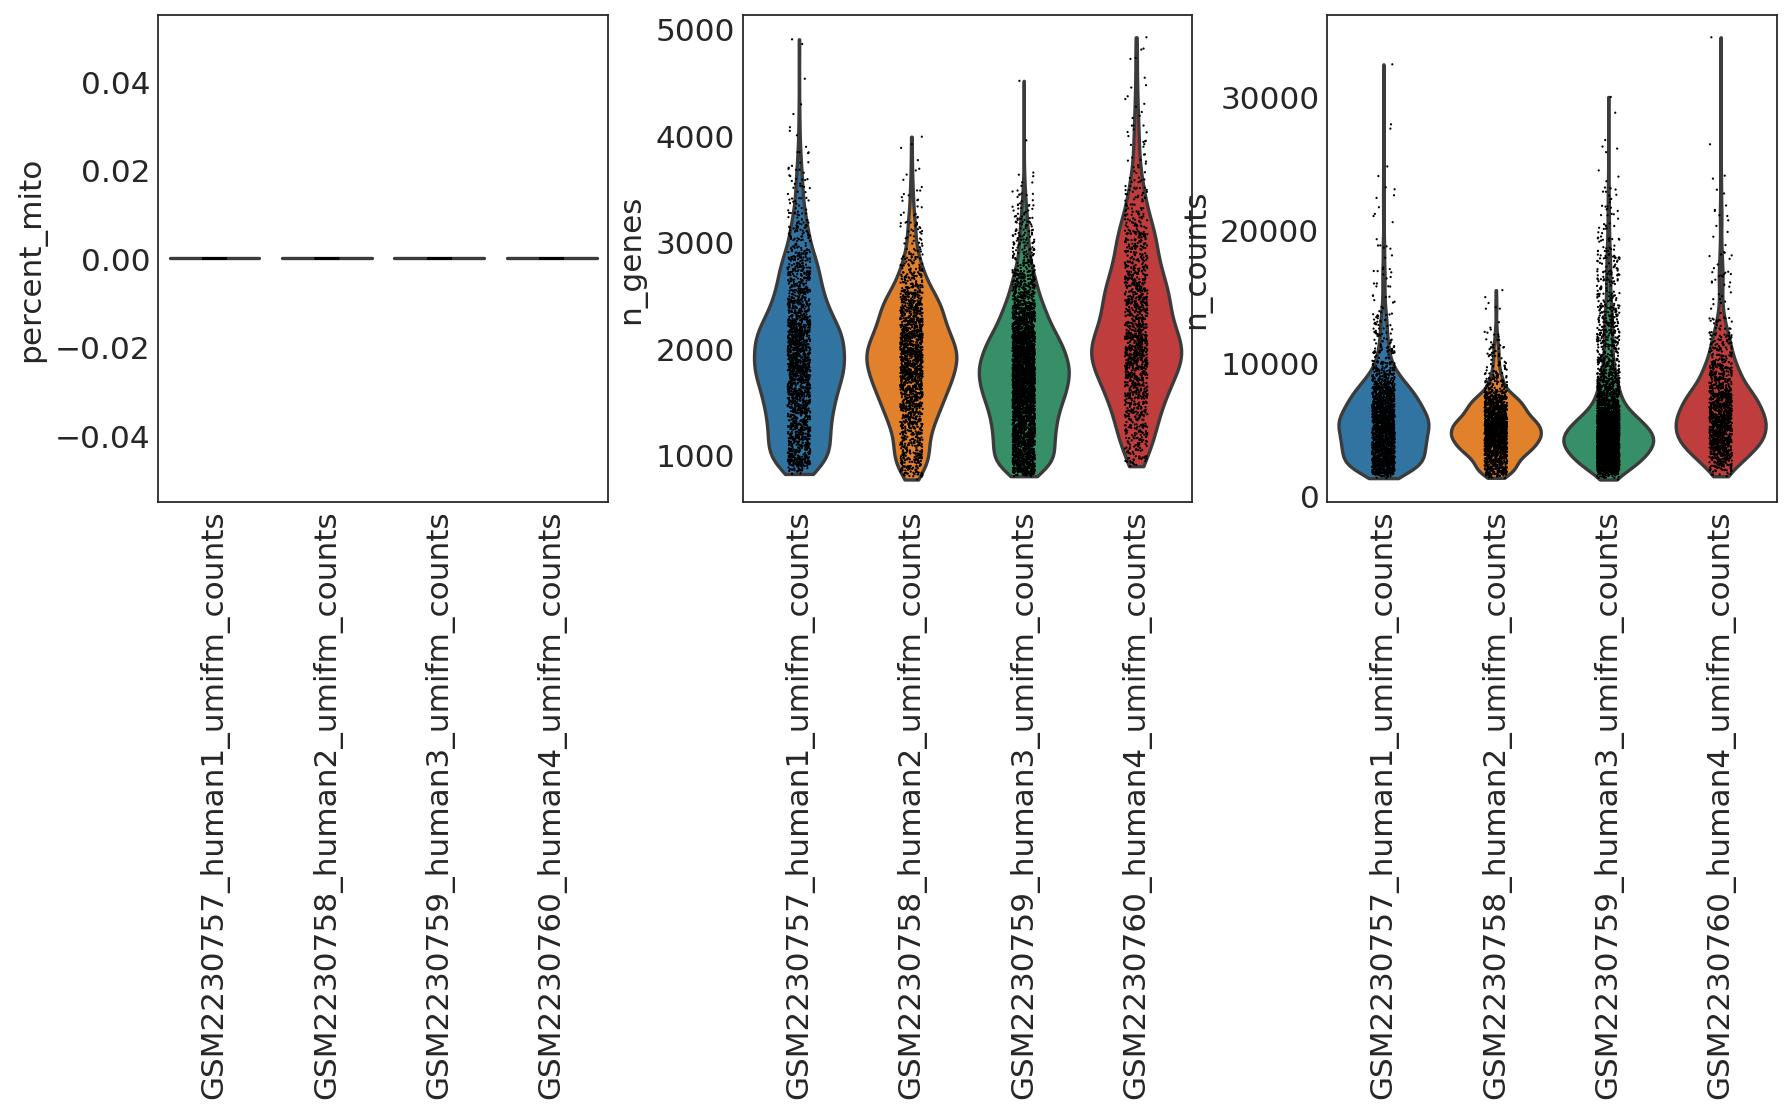

In [62]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.before_filtering.split.png')

### First filtering on gene and cell counts

In [63]:
%%capture filtering1
adata = bc.st.filtering_cells_genes_min(adata, standard_min_cells, standard_min_genes, standard_min_counts)

LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 8569 cells, 13784 genes
LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 8569 cells, 13784 genes
LOG MESSAGE: 	Time for filtering: 0.481s
LOG MESSAGE: 	Time for filtering: 0.481s


In [64]:
filtering1.show()

started with  8569  total cells and  20125  total genes
removed 0 cells that did not express at least 500  genes
removed 0 cells that did not have at least 1000 counts
removed 6341 genes that were not expressed in at least 30 cells
finished with 8569  total cells and 13784 total genes


### Second filtering on mitochondrial genes, and upper limit for gene number ###

In [65]:
%%capture filtering2
adata = bc.st.filtering_mito_genes_max(adata, standard_percent_mito, standard_n_genes, standard_max_counts)

LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 8569 cells, 13784 genes
LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 8569 cells, 13784 genes
LOG MESSAGE: 	Time for filtering: 0.316s
LOG MESSAGE: 	Time for filtering: 0.316s


In [66]:
filtering2.show()

started with  8569  total cells and  13784  total genes
removed 0 cells that expressed more than 5000 genes
removed 0 cells that had more than 140000  counts
removed  0  cells that expressed  10.0 percent mitochondrial genes or more
finished with 8569  total cells and 13784 total genes


###  Filtered dataset characteristics

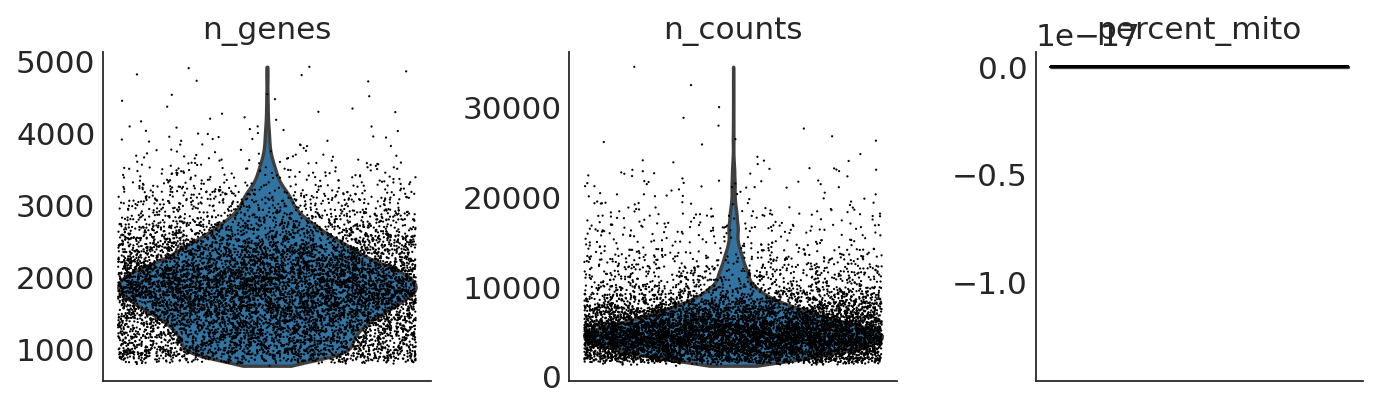

In [67]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.after_filtering.png')

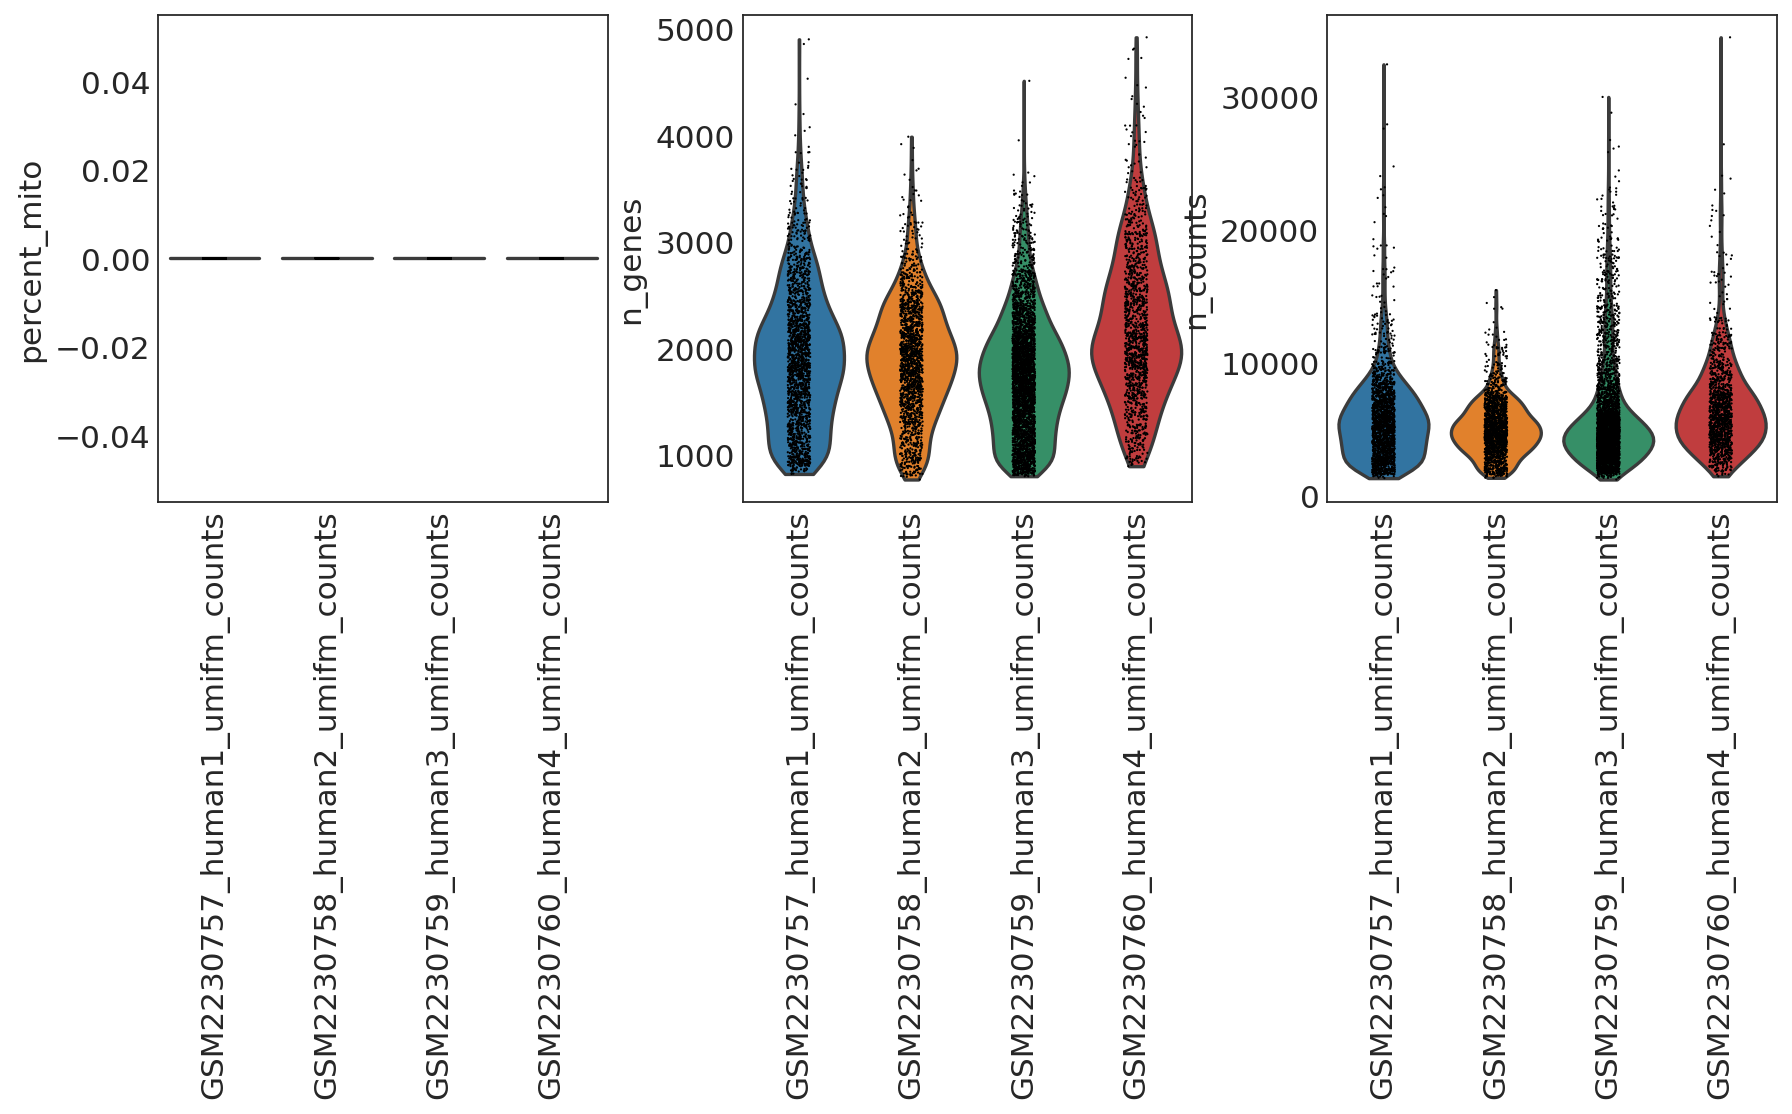

In [68]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.after_filtering.split.png')

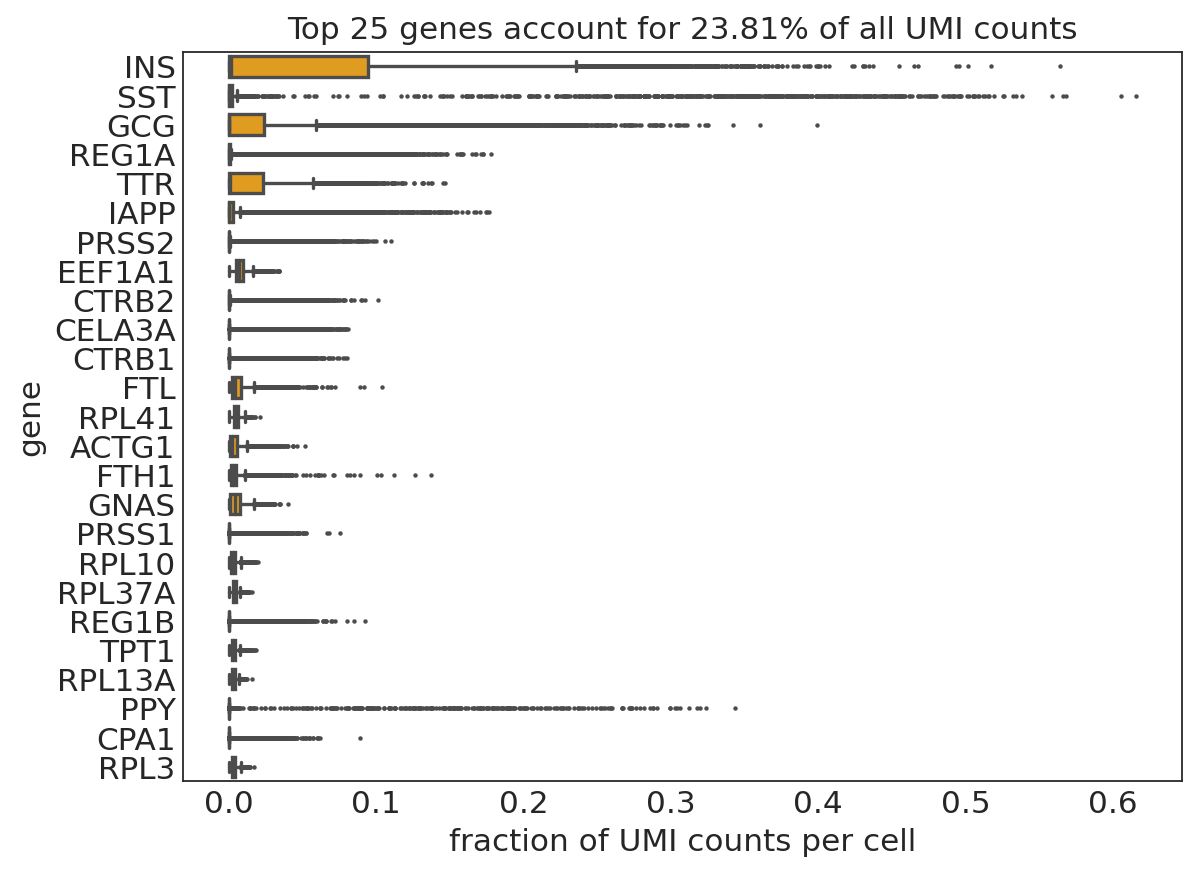

In [69]:
#display the top 25 genes in the dataset
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8, 6))
bc.pl.top_genes_counts(adata=adata, top_n=25, ax = ax )
fig.savefig(os.path.join(results_folder, 'figures/top_genes.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

### Per-cell normalization, and output of normalized results ###

In [70]:
adata = bc.st.per_cell_normalize(adata, results_folder)

adata normalized per cell


LOG MESSAGE: Per cell normalization completed successfully.
LOG MESSAGE: Per cell normalization completed successfully.
LOG MESSAGE: 	Time for per-cell normalization: 0.521s
LOG MESSAGE: 	Time for per-cell normalization: 0.521s


log1p values saved into adata.raw
writing out matrix.mtx ...


LOG MESSAGE: cp10k values exported to file.
LOG MESSAGE: cp10k values exported to file.
LOG MESSAGE: 	Time for cp10k export: 48.375s
LOG MESSAGE: 	Time for cp10k export: 48.375s


adata.X successfully written to matrix.mtx
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv
annotation successfully written out to metadata.tsv


In [71]:
dynrange

['B2M', 'ACTB', 'PGK1', 'CTCF']

CTCF can not be plotted


<Figure size 320x320 with 0 Axes>

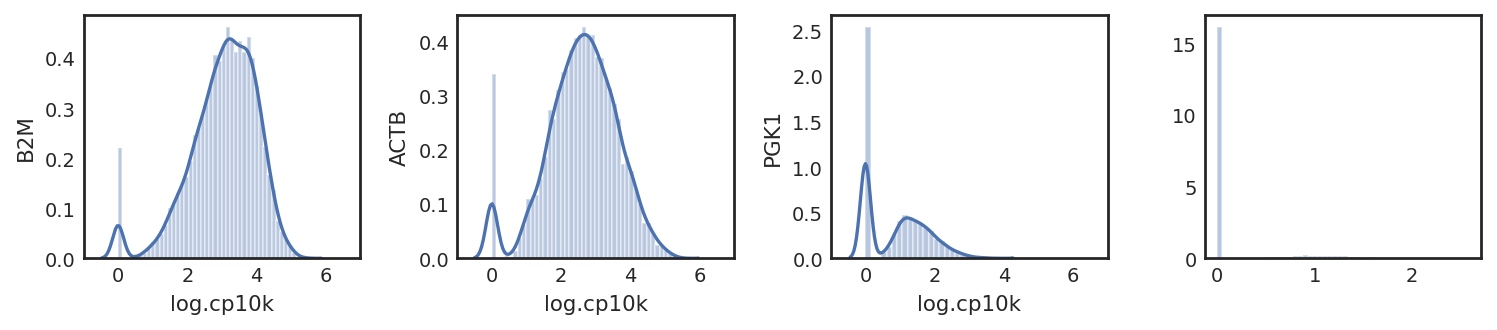

In [72]:
# Further QC: dynamic range of ubi/marker genes
fig = plt.figure()
sns.set(font_scale=0.8)
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(len(dynrange)*2.8,2))
fig.subplots_adjust(hspace=0.2, wspace=0.35)
for i in range(1,len(dynrange)+1):
    ax = fig.add_subplot(1, len(dynrange), i)
    myg=dynrange[i-1]
    try:
        g=sns.distplot(adata.raw[:,myg].X.toarray(), norm_hist=True)
        ax.set(xlabel='log.cp10k',ylabel=myg)
        g.set_xlim(-1, 7)
    except:
        print( myg + ' can not be plotted')
    


### Feature selection (highly variable genes) for clustering ###

log1p taken of adata


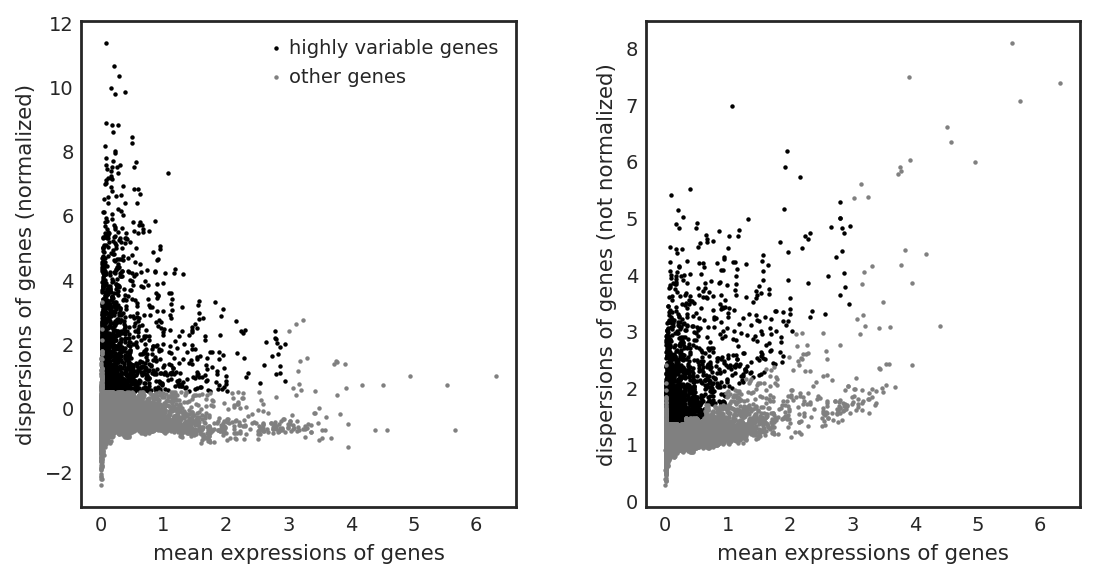

LOG MESSAGE: After feature selection of highly variable genes: 8569 cells, 1839 genes
LOG MESSAGE: After feature selection of highly variable genes: 8569 cells, 1839 genes
LOG MESSAGE: 	Time for feature selection: 3.157s
LOG MESSAGE: 	Time for feature selection: 3.157s


In [73]:
adata = bc.st.highly_variable_genes(adata)

### Regression steps, and output of regressed data ###

In [74]:
adata 

View of AnnData object with n_obs × n_vars = 8569 × 1839 
    obs: 'Individual', 'assigned_cluster', 'barcode', 'percent_mito', 'n_counts', 'n_genes'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads'
    uns: 'Individual_colors', 'log1p'

In [75]:
# RMK : AS OF FEB 2020 there is a bug in scanpy regress out if scanpy installed with PIP (see https://github.com/theislab/scanpy/issues/707)
# Before the fix is available, one should coopy the data toprevet it. hence the adata = adata.copy()
adata = adata.copy()
adata = bc.st.regress_out(adata, results_folder)

LOG MESSAGE: Regression steps completed. 'n_counts' and 'percent_mito' regressed out. adata was log-normalized and scaled.
LOG MESSAGE: Regression steps completed. 'n_counts' and 'percent_mito' regressed out. adata was log-normalized and scaled.
LOG MESSAGE: 	Time for regression steps: 12.542s
LOG MESSAGE: 	Time for regression steps: 12.542s


'n_counts' and 'percent_mito' regressed out
adata scaled with max_value set to 10


### Batch correction and PCA neighbor analysis and UMAP

The standard workflow uses bbknn as  batch correction method.


Using random_state = 0 for all the following calculations
PCA calculated using svd_solver = 'arpack'. PCA multiplied by -1 to match Seurat output.


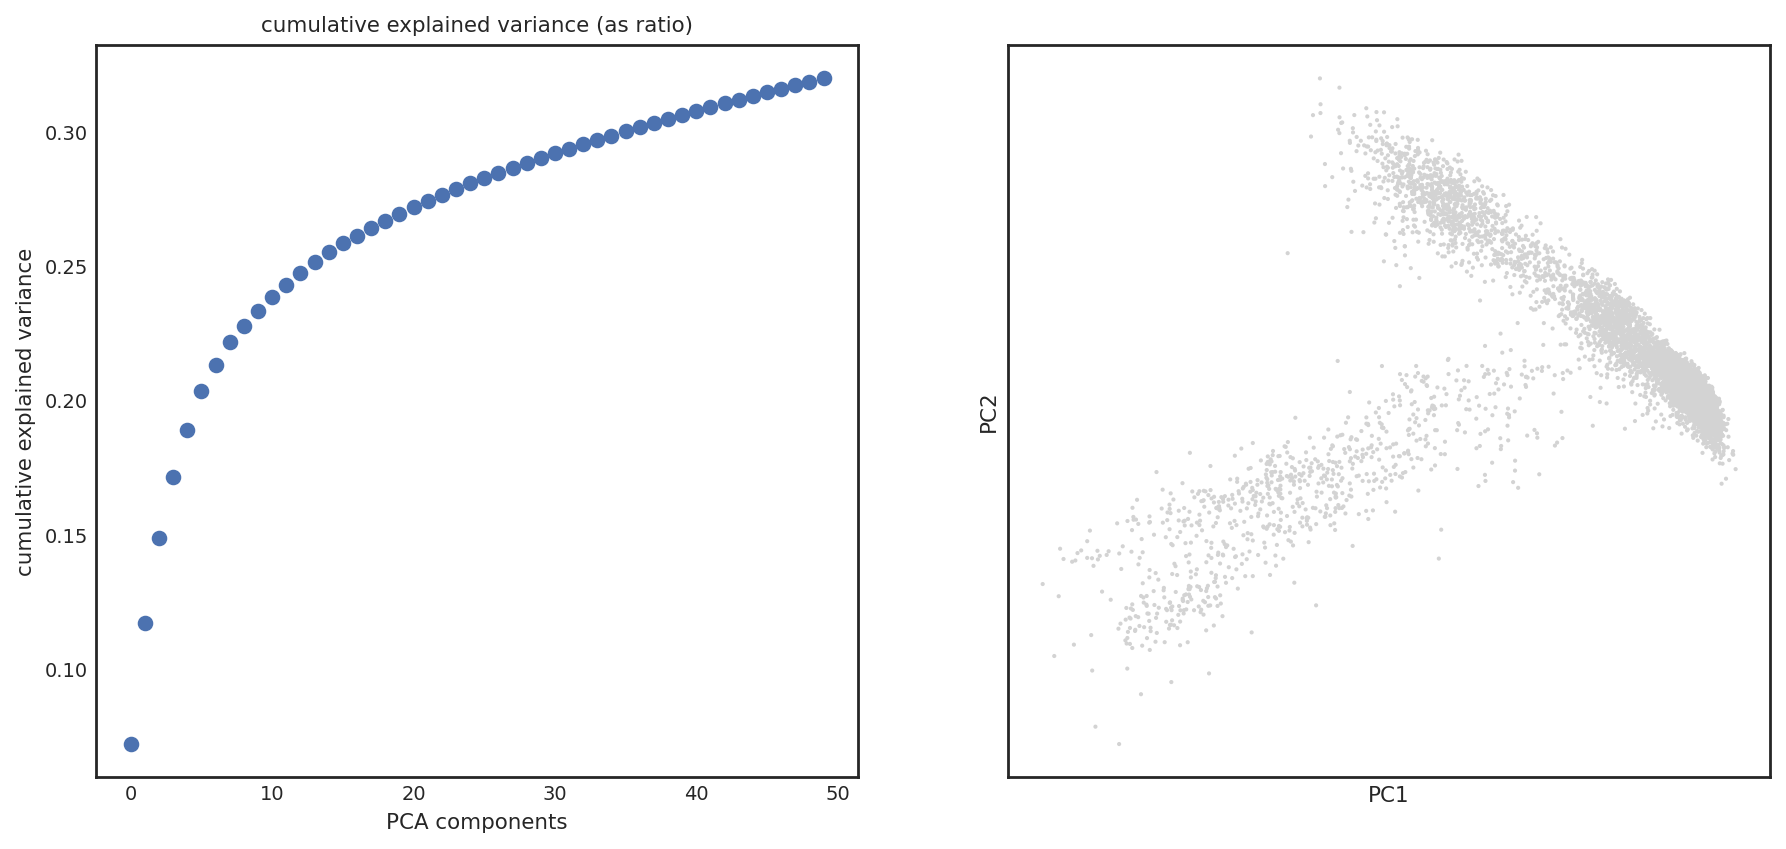

Nearest neighbors calculated with n_neighbors = 10


LOG MESSAGE: Neighborhood analysis completed, and UMAP generated.
LOG MESSAGE: Neighborhood analysis completed, and UMAP generated.
LOG MESSAGE: 	 Time for PCA, nearest neighbor calculation and UMAP generation: 20.457s
LOG MESSAGE: 	 Time for PCA, nearest neighbor calculation and UMAP generation: 20.457s
LOG MESSAGE: Metadata containing 3 PCAs and UMAP coordinates exported successfully to file.
LOG MESSAGE: Metadata containing 3 PCAs and UMAP coordinates exported successfully to file.
LOG MESSAGE: Time for export: 0.117s
LOG MESSAGE: Time for export: 0.117s


UMAP coordinates calculated.
results successfully written out to 'analysis_metadata.tsv'


In [76]:
if (batch_to_correct != 'None'):
    #save a copy of uncorrected in case we need it for something later
    adata_uncorrected = adata.copy()
    adata.obs['batch'] = adata.obs[batch_to_correct]
    adata = bc.st.pca_neighbors_umap(adata,results_folder, method='bbknn')
else:
    adata = bc.st.pca_neighbors_umap(adata, results_folder)
    

### Clustering ###

leiden clustering performed with a resolution of 1


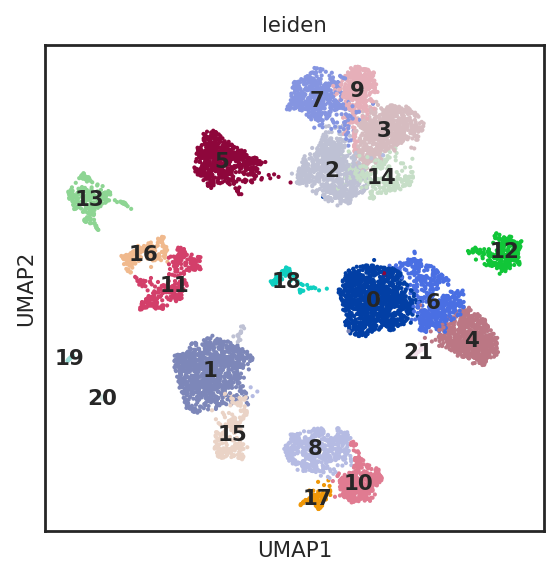

LOG MESSAGE: leidenclustering done. Found 22 clusters.
LOG MESSAGE: leidenclustering done. Found 22 clusters.
LOG MESSAGE: 	Time for leiden clustering: 1.513s
LOG MESSAGE: 	Time for leiden clustering: 1.513s
LOG MESSAGE: Marker gene detection performed on a per-cluster basis using the method wilcoxon.
LOG MESSAGE: Marker gene detection performed on a per-cluster basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 10.509s
LOG MESSAGE: 	Time for marker gene detection: 10.509s


rank genes per cluster calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
.//analyzed/standard_workflow_besca2.0/labelings/leiden/WilxRank.gct written out
.//analyzed/standard_workflow_besca2.0/labelings/leiden/WilxRank.pvalues.gct written out


LOG MESSAGE: Cluster level analysis and marker genes exported to file.
LOG MESSAGE: Cluster level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 3.799s
LOG MESSAGE: 	Time for export of cluster level analysis: 3.799s


.//analyzed/standard_workflow_besca2.0/labelings/leiden/WilxRank.logFC.gct written out


In [77]:
# leiden clustering is the default 
adata = bc.st.clustering(adata, results_folder)

In [78]:
# everything that was done so far goes to the .h5ad file for later use
adata.write(results_file)
print(results_file)

.//analyzed/standard_workflow_besca2.0/standard_workflow_besca2.0.h5ad


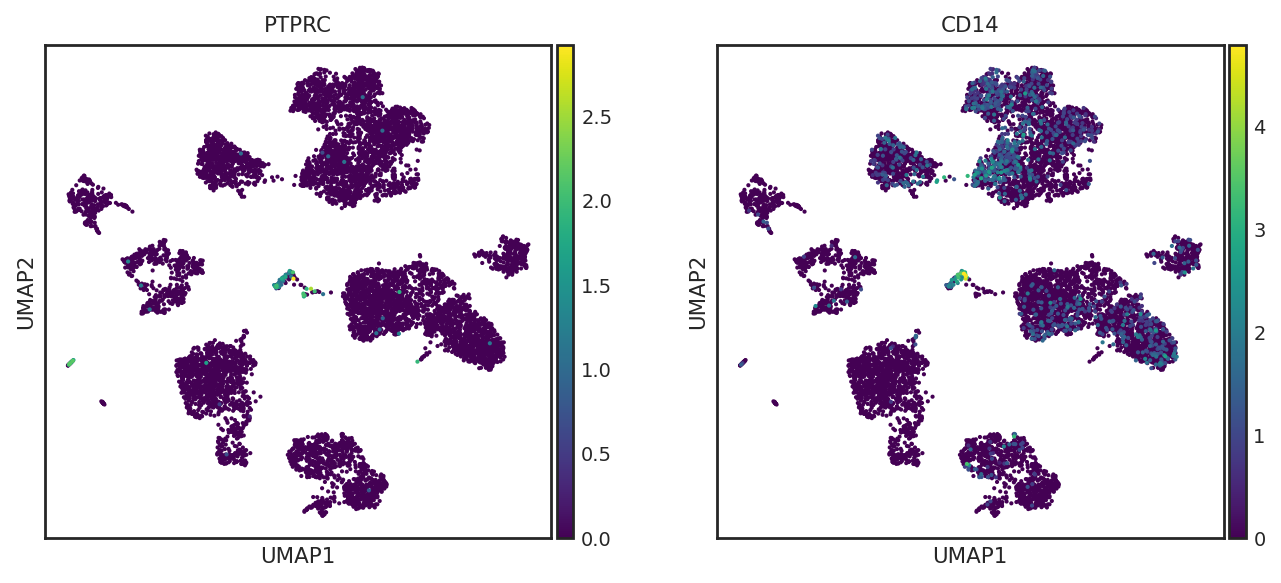

In [79]:
sc.pl.umap( adata, color=['PTPRC', 'CD14'], color_map = 'viridis')

### Additional Labeling ###

(if specified) based on external annotation in "metadata.tsv"  the additional labeling will be exported to file and the fract_pos.gct and average.gct files generated

In [80]:
adata

AnnData object with n_obs × n_vars = 8569 × 1839 
    obs: 'Individual', 'assigned_cluster', 'barcode', 'percent_mito', 'n_counts', 'n_genes', 'leiden'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads'
    uns: 'Individual_colors', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

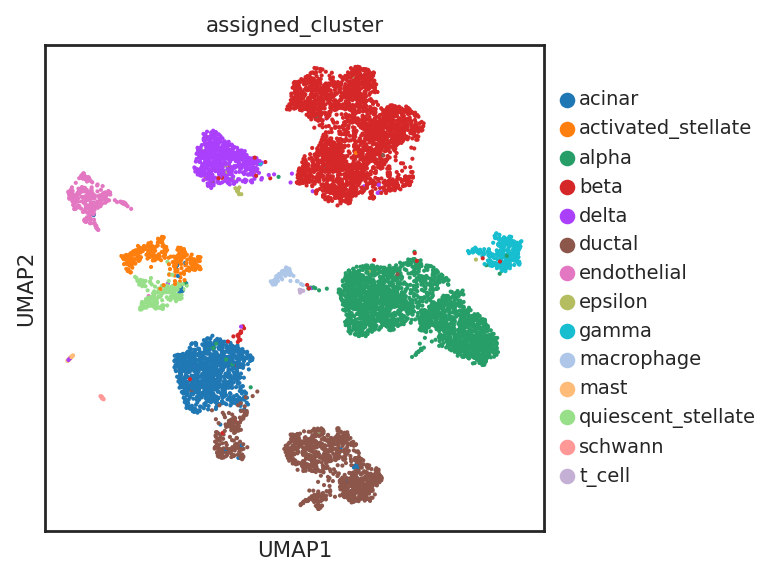

In [81]:
sc.pl.umap( adata, color  = ['assigned_cluster'] )

In [82]:
if (labeling_to_use != 'None'):
    adata = bc.st.additional_labeling(adata, labeling_to_use, labeling_name, labeling_description, labeling_author, results_folder)

LOG MESSAGE: Marker gene detection performed on a per-label basis using the method wilcoxon.
LOG MESSAGE: Marker gene detection performed on a per-label basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 9.226s
LOG MESSAGE: 	Time for marker gene detection: 9.226s


rank genes per label calculated using method wilcoxon.
mapping of cells to  assigned_cluster exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
.//analyzed/standard_workflow_besca2.0/labelings/assigned_cluster/WilxRank.gct written out
.//analyzed/standard_workflow_besca2.0/labelings/assigned_cluster/WilxRank.pvalues.gct written out


LOG MESSAGE: Label level analysis and marker genes exported to file.
LOG MESSAGE: Label level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 2.707s
LOG MESSAGE: 	Time for export of cluster level analysis: 2.707s


.//analyzed/standard_workflow_besca2.0/labelings/assigned_cluster/WilxRank.logFC.gct written out


### Complete log-file

In [83]:
logging.info('Entire workflow completed.')
logging.info('\tTime for entire workflow: '+str(round(time.time()-start0, 3))+'s')

LOG MESSAGE: Entire workflow completed.
LOG MESSAGE: Entire workflow completed.
LOG MESSAGE: 	Time for entire workflow: 135.82s
LOG MESSAGE: 	Time for entire workflow: 135.82s


### Write QC Report

In [84]:
bc.st.write_qc(adata_unfiltered = adata_unfiltered, 
                 adata_filtered = adata,
                 version = version, 
                 analysis_name = analysis_name, 
                 standard_min_genes = standard_min_genes, 
                 standard_min_cells = standard_min_cells, 
                 standard_min_counts = standard_min_counts, 
                 standard_percent_mito = standard_percent_mito, 
                 standard_max_counts = standard_max_counts,
                 standard_n_genes = standard_n_genes,
                 filtering_output1 = filtering1,
                 filtering_output2 = filtering2,
                 results_folder = results_folder,
                 css_path = os.path.join(os.path.dirname(bc.__file__),'st', 'style.css'))
logging.info('QC Report generated and saved as .html')

LOG MESSAGE: QC Report generated and saved as .html
LOG MESSAGE: QC Report generated and saved as .html
